In [1]:
# !pip install --upgrade torch torchvision
# !pip install sklearn
# !pip install efficientnet_pytorch
# !pip install scikit-image
import numpy as np
import pandas as pd
from PIL import Image, ImageFile , ImageCms
ImageFile.LOAD_TRUNCATED_IMAGES = True
import sys
import os
import time
import shutil
import matplotlib.pyplot as plt
import matplotlib.pyplot as imshow
from collections import Counter
from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import MemoryEfficientSwish

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import  SubsetRandomSampler, WeightedRandomSampler


from torchvision import models
import torchvision.transforms as transforms

import pickle
import copy
import warnings
warnings.filterwarnings('ignore')
print(torch.__version__)
print(torch.cuda.is_available())

print('-----loaded libraries-----')

1.8.1+cu102
True
-----loaded libraries-----


In [2]:
model_name = 'blidness_detection_resnext101'
random_seed = 123
num_classes = 5
batch_size = 4
epochs = 20
lr = 0.000001
pre_trained = True
model_path = model_name+'.pkl'
output_path = model_name+'.csv'

print('-----initialised parameters-----')

-----initialised parameters-----


In [3]:
def train_validation_split(data_path):
    split = []
    scores =  pd.read_csv(data_path+'train.csv')
    _ , val_idx = train_test_split(np.arange(len(scores.id_code)), test_size=0.2, shuffle=True, stratify= scores.diagnosis)
    if not os.path.isdir(data_path+'val_images'):
        os.mkdir(data_path+'val_images')
    for i, img in enumerate(scores.id_code):
        if i in val_idx:
            shutil.move(data_path+'train_images/'+img+".png", data_path+'val_images/'+img+".png")
            split.append('val')
        else:
            split.append('train')
    scores['split'] = split
    scores.to_csv(data_path+'train_val.csv')

In [ ]:
data_path = "./dataset/"
train_validation_split(data_path)

In [4]:
class BlindnessDataset(Dataset):
    def __init__(self, scores_df,data_path,num_classes = 5):
        self.scores = scores_df.diagnosis
        self.file_names = scores_df.id_code
        self.num_classes = num_classes
        self.data_path = data_path
          
    def _transform(self, image):
        transform = transforms.Compose([transforms.Resize((512, 512)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
        return transform(image)
    
    def get_train_val_indices(self):
        train_idx, val_idx = train_test_split(
        np.arange(len(self.scores)),
        test_size=0.2,
        shuffle=True,
        stratify=self.scores)
        return train_idx, val_idx
        
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name = self.file_names[index]
        # Get Images of the patient
        image = self._transform(Image.open(self.data_path+'train_images/'+file_name+'.png').convert('RGB'))
        label = self.scores[index]
        levels = [1]*label + [0]*(self.num_classes - 1 - label)
        levels = torch.tensor(levels, dtype=torch.float32)
        return image, label, levels

In [5]:
data_path = './dataset/'
scores =  pd.read_csv(data_path+'train.csv')
dataset = BlindnessDataset(scores_df = scores, data_path = data_path,num_classes=num_classes)


In [6]:
scores.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [ ]:
%matplotlib inline
idx = 378
b = np.rollaxis(dataset[idx][0].numpy(),0,3)
print('The blindess severity for image ' + dataset.file_names[idx] +'is: ' + str(dataset[idx][1]))
plt.imshow(b)

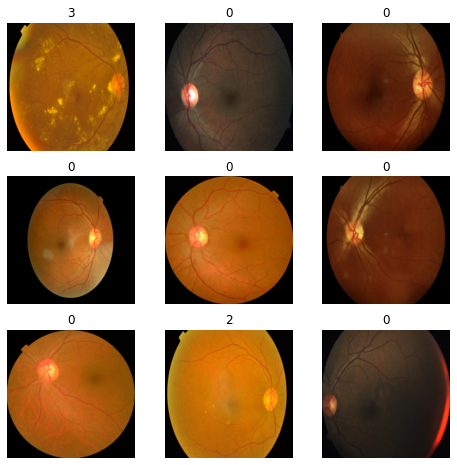

In [16]:
def visualise_samples(dataset, rows = 3, cols = 3):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = np.rollaxis(dataset[idx][0].numpy(),0,3), dataset[idx][1]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img)
    plt.show()
visualise_samples(dataset)

In [ ]:
train_idx,val_idx = dataset.get_train_val_indices()

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(dataset, batch_size = batch_size,sampler = train_sampler)
val_loader = DataLoader(dataset, batch_size = batch_size,sampler = val_sampler)

In [ ]:
# def compute_weights(dataset):
#     counts = sorted(Counter(dataset.scores).items())
#     class_sample_counts = [x[1] for x in counts]
#     weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
#     samples_weights = weights[dataset.scores]
#     return weights,samples_weights

# weights,samples_weights = compute_weights(train_dataset)
# print(sorted(Counter(train_dataset.scores).items()))
# print(weights)

# sampler = WeightedRandomSampler(
#     weights=samples_weights,
#     num_samples=len(samples_weights),
#     replacement=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler =sampler)
data_loaders = {'train': train_loader, 'val': val_loader}
print('-----created dataloaders-----')

In [ ]:
class model_classifier(nn.Module):
    def __init__(self, num_classes=5, pretrained=True):
        super(model_classifier, self).__init__()
        resnext = models.resnext50_32x4d(pretrained = pretrained, progress = False)
        self.fc_in_features = resnext.fc.in_features
        self.features = nn.Sequential(*list(resnext.children())[:-1])
        self.num_classes = num_classes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_in_features, (self.num_classes-1)*2)
        )

    def forward(self, inputs): # inputs.shape = samples x height x width x channels
        x = self.features(inputs)
        logits = self.classifier(x)
        logits = logits.view(-1, (self.num_classes-1), 2)
        probas = nn.functional.softmax(logits, dim=2)[:, :, 1]
        return logits, probas
    
model = model_classifier(num_classes=num_classes)
print('-----created model-----')

In [ ]:
# DEFINE THE DEVICE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count()>1:
    print('Number of GPUs: '+ str(torch.cuda.device_count()))
    model = nn.DataParallel(model)

In [ ]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)
    m = torch.zeros(uniq.shape[0])
    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

dt = torch.tensor(scores.diagnosis, dtype=torch.float)
imp = task_importance_weights(dt)
imp = imp[0:num_classes-1]
imp = imp.to(device)
imp

In [ ]:
def cost_fn(logits, levels, imp, reduction = "mean"):
    val = (-torch.sum((nn.functional.log_softmax(logits, dim=2)[:, :, 1]*levels
                      + nn.functional.log_softmax(logits, dim=2)[:, :, 0]*(1-levels))*imp, dim=1))
    if reduction == "none":
        return val
    elif reduction == "mean":
        return torch.mean(val)
    else:
        return torch.mean(val)
    

In [ ]:
# DEFINE A FUNCTION TO TRAIN THE MODEL
def train_model(model, dataloaders, optimizer, lr_scheduler, model_path, imp_weights, output_path, num_epochs=25):
    since = time.time()
    val_kappa_history = []
    val_loss_history = []
    train_kappa_history = []
    train_loss_history = []

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_kappa = 0.0
    for epoch in range(1, num_epochs+1):
        
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            mae = 0
            kappa = 0
            all_preds = []
            all_labels = []
            # Iterate over data.
            for batch_idx, (inputs, labels, levels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                levels = levels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # FORWARD AND BACK PROP
                    logits, probas = model(inputs)
                    loss = cost_fn(logits, levels, imp_weights)
                    # Get model predictions
                    pred = probas > 0.5
                    preds =  torch.sum(pred,dim = 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                mae += torch.sum(torch.abs(preds - labels))
                all_preds.append(preds)
                all_labels.append(labels)
            epoch_loss = running_loss / len(dataloaders[phase].sampler)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)
            epoch_mae = mae.double() / len(dataloaders[phase].sampler)
            all_labels = torch.cat(all_labels, 0)
            all_preds = torch.cat(all_preds, 0)
            kappa = cohen_kappa_score(all_labels.cpu().numpy(),all_preds.cpu().numpy(), weights = 'quadratic')
            if phase == 'val':
                lr_scheduler.step(epoch_loss)
            if epoch == 1 and phase == 'train':
                df = pd.DataFrame({'epoch': epoch,'phase':phase, 'epoch_loss':epoch_loss,'epoch_acc':epoch_acc.cpu().numpy(),'epoch_mae':epoch_mae.cpu().numpy(),'QWK':kappa}, index=[0])
                df.to_csv(output_path,mode = 'a',header=True)	
                print('-----wrote first output-----')
            else:
                df = pd.DataFrame({'epoch': epoch,'phase':phase, 'epoch_loss':epoch_loss,'epoch_acc':epoch_acc.cpu().numpy(),'epoch_mae':epoch_mae.cpu().numpy(),'QWK':kappa}, index=[0])
                df.to_csv(output_path,mode = 'a',header=False)

            print('{} Loss: {:.4f} - Acc: {:.4f} - MAE: {:.4f} - QWK: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_mae, kappa))

            # deep copy the model
            if phase == 'val' and kappa > best_kappa:
                best_kappa = kappa
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_path)
                print('-----saved model------')

            if phase == 'train':
                train_kappa_history.append(kappa)
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_kappa_history.append(kappa)
                val_loss_history.append(epoch_loss)
            	
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val QWK: {:4f}'.format(best_kappa))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_kappa_history, val_kappa_history

In [ ]:
print('-----start training-----')
# TRAIN THE NETWORK 
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 0.1)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,verbose = True)
model, train_loss_history, val_loss_history, train_kappa_history, val_kappa_history = train_model(model=model, dataloaders=data_loaders, optimizer = optimizer, lr_scheduler=lr_scheduler, model_path = model_path, imp_weights = imp, output_path = output_path, num_epochs=epochs)